In [4]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats

# Dataset

In [5]:
jerks_path = "Synthesised_Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Synthesised_Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Synthesised_Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Synthesised_Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Synthesised_Dataset/Appropriateness_Features/RMS_Distance_scores_windowed.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Synthesised_Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [6]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [7]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['idx'] = XY['StudySeq']
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/80)):
    XY.iloc[i*80:(i+1)*80,-5:] = XX_rms_energy_properties

In [8]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)
XY.set_index('idx', inplace=True)
# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(7200, 137)


In [9]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
YY = XY.loc[:,'Mean_Appropriateness_Score']
XX = np.log(XX)
print(XX.shape)
print(YY.shape)

(7200, 136)
(7200,)


198.63134441390545


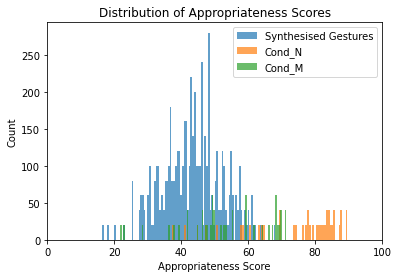

In [10]:
plt.hist(YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], bins = 100, label='Synthesised Gestures', alpha=0.7)
plt.hist(YY.loc[['Cond_N' in idx for idx in YY.index]], bins = 100, label='Cond_N', alpha=0.7)
plt.hist(YY.loc[['Cond_M' in idx for idx in YY.index]], bins = 100, label='Cond_M', alpha=0.7)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Count")
plt.title("Distribution of Appropriateness Scores")
plt.legend()
var = np.var(YY)
print(var)

198.63134441390545


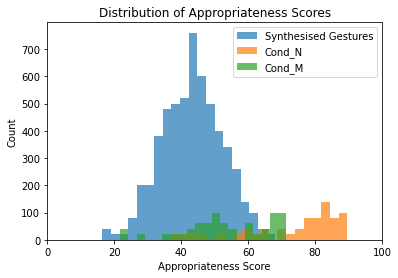

In [11]:
plt.hist(YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], bins = 20, label='Synthesised Gestures', alpha=0.7)
plt.hist(YY.loc[['Cond_N' in idx for idx in YY.index]], bins = 20, label='Cond_N', alpha=0.7)
plt.hist(YY.loc[['Cond_M' in idx for idx in YY.index]], bins = 20, label='Cond_M', alpha=0.7)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Count")
plt.title("Distribution of Appropriateness Scores")
plt.legend()
var = np.var(YY)
print(var)

Sort features in terms of correlation between Appropriateness and Feature

In [12]:
pcc_vals = []
for i in XX.columns:
    rho, pval = stats.spearmanr(XX[i], YY)
    pcc_vals = pcc_vals + [rho]

abs_pcc_vals = np.abs(pcc_vals)
sorted_abs_pcc_vals = np.sort(abs_pcc_vals)

sorted_features = []
for i in sorted_abs_pcc_vals:
    feature_index = np.where(abs_pcc_vals == i)
    sorted_features = sorted_features + [XX.columns[feature_index]]

print("Feature with Highest Correlation: ", sorted_features[-1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-1][0])[0][0]])
print("Feature with 2nd Highest Correlation: ", sorted_features[-2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-2][0])[0][0]])
print("Feature with 3rd Highest Correlation: ", sorted_features[-3][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-3][0])[0][0]])
print("Feature with 3rd Lowest Correlation: ", sorted_features[2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[2][0])[0][0]])
print("Feature with 2nd Lowest Correlation: ", sorted_features[1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[1][0])[0][0]])
print("Feature with Lowest Correlation: ", sorted_features[0][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[0][0])[0][0]])

print("Mean Feature PCC (absolute): ", np.mean(sorted_abs_pcc_vals), "with stdev: ", np.std(sorted_abs_pcc_vals))

Feature with Highest Correlation:  LeftShoulder_RMS_Distance_Score  - PCC = 0.3874996656078598
Feature with 2nd Highest Correlation:  LeftArm_RMS_Distance_Score  - PCC = 0.3861461768730174
Feature with 3rd Highest Correlation:  Spine1_RMS_Distance_Score  - PCC = 0.3859341340313138
Feature with 3rd Lowest Correlation:  LeftForearm_jerks  - PCC = -0.002788825167421171
Feature with 2nd Lowest Correlation:  LeftForearm_jerks  - PCC = -0.002788825167421171
Feature with Lowest Correlation:  Neck1_jerks  - PCC = -0.0020770326835699462
Mean Feature PCC (absolute):  0.14319535762563376 with stdev:  0.10582023261693697


Text(0.5, 1.0, 'Distribution of Feature PCCs')

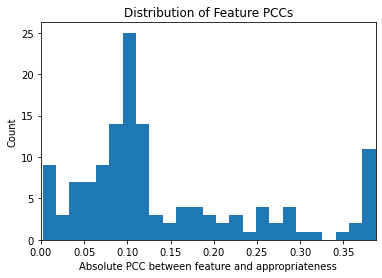

In [13]:
bins = 25
plt.hist(abs_pcc_vals, bins = bins)
plt.xlim(0,max(abs_pcc_vals))
plt.xlabel("Absolute PCC between feature and appropriateness")
plt.ylabel("Count")
plt.title("Distribution of Feature PCCs")

In [14]:
XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])]

Spine1_jerks  Spine2_jerks  Spine3_jerks  \
idx                                                             
Cond_BA/StudySeq1        4.685833      5.411104      5.878632   
Cond_BA/StudySeq2        4.794414      5.491201      5.933963   
Cond_BA/StudySeq3        4.641790      5.373085      5.848681   
Cond_BA/StudySeq4        4.542846      5.256153      5.713922   
Cond_BA/StudySeq5        4.344198      5.028202      5.490168   
...                           ...           ...           ...   
Cond_SE/StudySeq796      7.435212      7.528374      7.661698   
Cond_SE/StudySeq797      7.371239      7.457367      7.596699   
Cond_SE/StudySeq798      7.411375      7.497233      7.605269   
Cond_SE/StudySeq799      7.383466      7.476675      7.599275   
Cond_SE/StudySeq800      7.428526      7.483356      7.566771   

                     LeftShoulder_jerks  LeftArm_jerks  LeftForearm_jerks  \
idx                                                                         
Cond_BA/StudySeq1              6.194287       6.654608           7.431837   
Cond_BA/StudySeq2              6.253794       6.713159           7.475203   
Cond_BA/StudySeq3              6.152784       6.634901           7.446747   
Cond_BA/StudySeq4              6.057099       6.488468           7.652750   
Cond_BA/StudySeq5              5.835539       6.388440           7.772797   
...                                 ...            ...                ...   
Cond_SE/StudySeq796            7.800049       7.880207           8.243724   
Cond_SE/StudySeq797            7.736340       7.862727           8.202218   
Cond_SE/StudySeq798            7.729369       7.834649           7.984944   
Cond_SE/StudySeq799            7.732076       7.880179           8.209248   
Cond_SE/StudySeq800            7.658222       7.750983           8.076561   

                     LeftHand_jerks  RightShoulder_jerks  RightArm_jerks  \
idx                                                                        
Cond_BA/StudySeq1          8.474055             6.194249        6.474088   
Cond_BA/StudySeq2          8.674891             6.253755        6.409670   
Cond_BA/StudySeq3          8.324778             6.152773        6.423095   
Cond_BA/StudySeq4          8.665599             6.057132        6.482450   
Cond_BA/StudySeq5          8.492025             5.835528        6.345554   
...                             ...                  ...             ...   
Cond_SE/StudySeq796        8.874665             7.800056        7.938983   
Cond_SE/StudySeq797        8.995213             7.736335        7.886763   
Cond_SE/StudySeq798        8.443258             7.729385        7.877382   
Cond_SE/StudySeq799        9.046149             7.732063        7.863898   
Cond_SE/StudySeq800        8.616048             7.658264        7.800990   

                     RightForearm_jerks  ...  \
idx                                      ...   
Cond_BA/StudySeq1              7.639084  ...   
Cond_BA/StudySeq2              7.597684  ...   
Cond_BA/StudySeq3              7.634566  ...   
Cond_BA/StudySeq4              8.016873  ...   
Cond_BA/StudySeq5              8.034707  ...   
...                                 ...  ...   
Cond_SE/StudySeq796            8.130559  ...   
Cond_SE/StudySeq797            8.121096  ...   
Cond_SE/StudySeq798            7.943063  ...   
Cond_SE/StudySeq799            8.128194  ...   
Cond_SE/StudySeq800            8.044047  ...   

                     RightShoulder_RMS_Distance_Score  \
idx                                                     
Cond_BA/StudySeq1                           -1.172275   
Cond_BA/StudySeq2                           -1.290502   
Cond_BA/StudySeq3                           -1.757577   
Cond_BA/StudySeq4                           -1.844050   
Cond_BA/StudySeq5                           -2.153768   
...                                               ...   
Cond_SE/StudySeq796                         -1.354407   
Cond_SE/StudySeq797                         -1

Plots of Highest and Lowest Correlated Features vs Appropriateness Scores

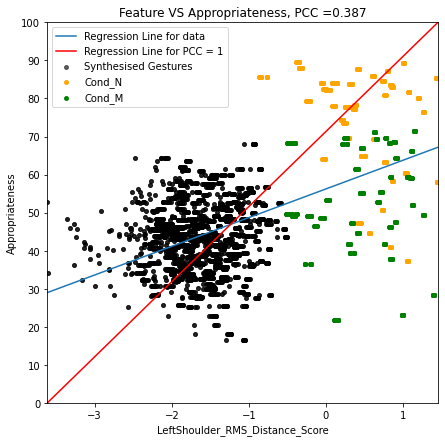

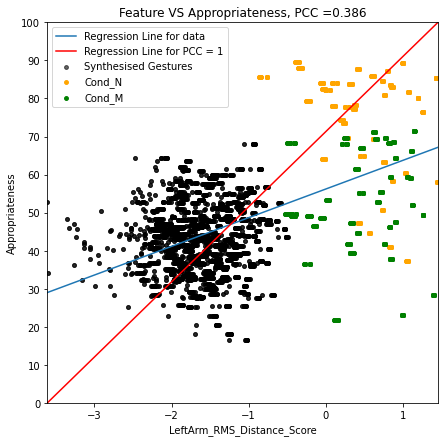

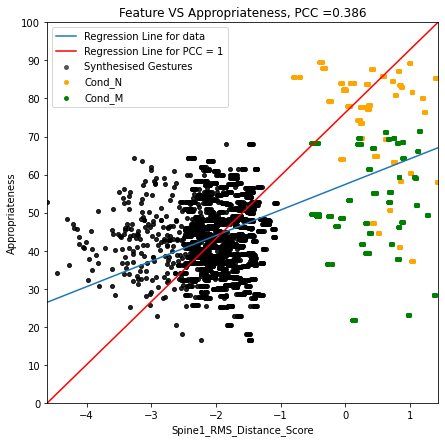

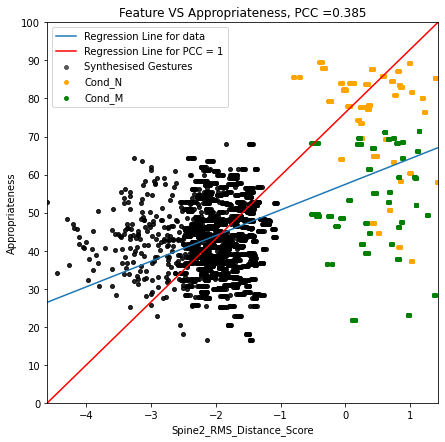

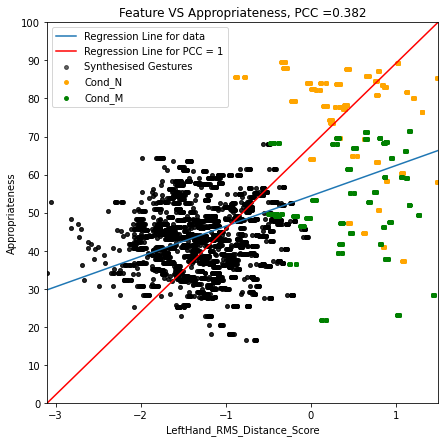

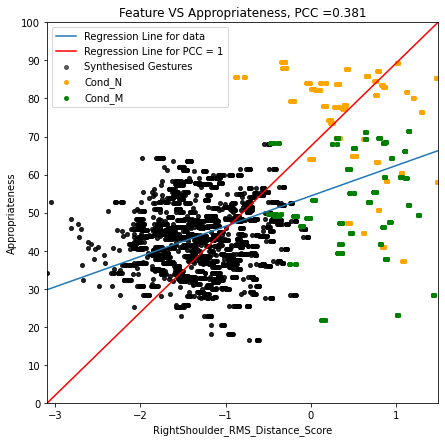

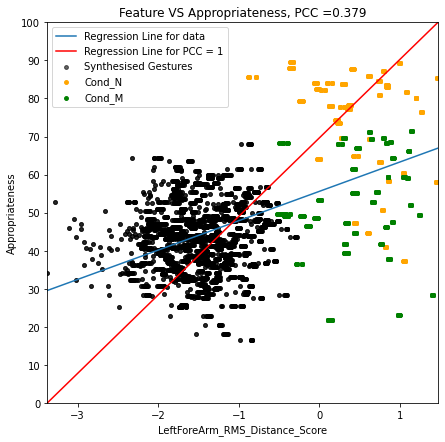

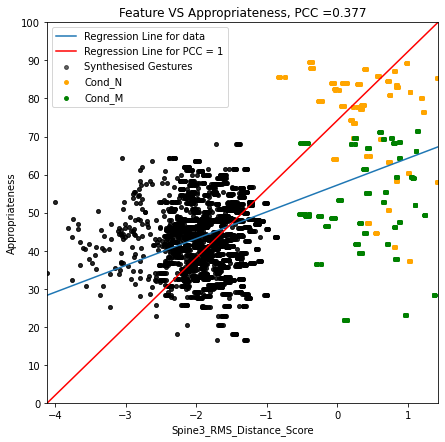

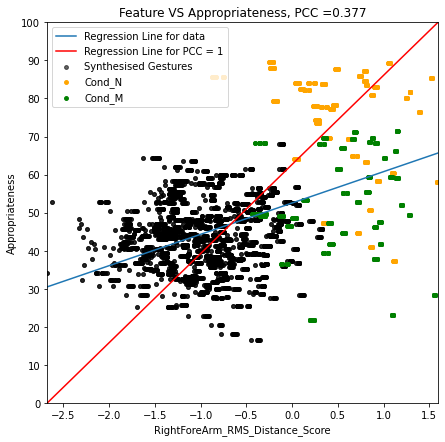

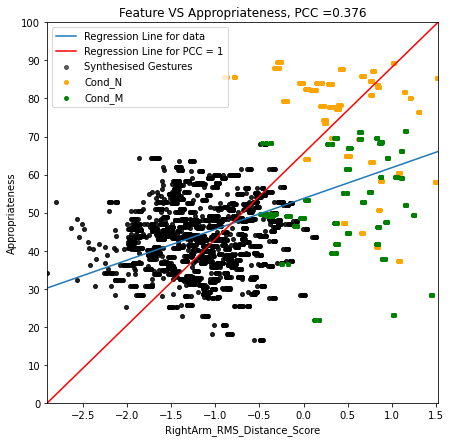

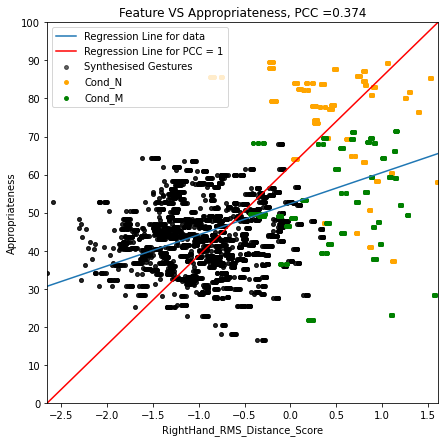

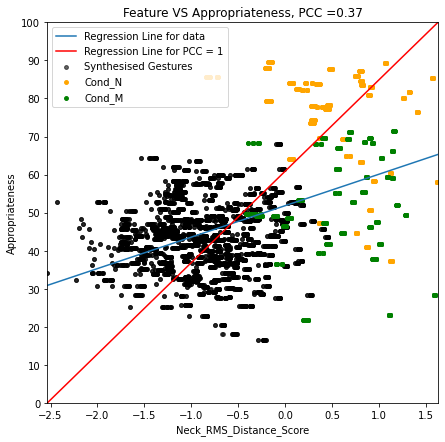

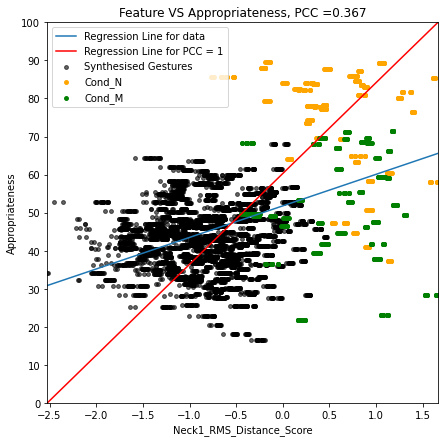

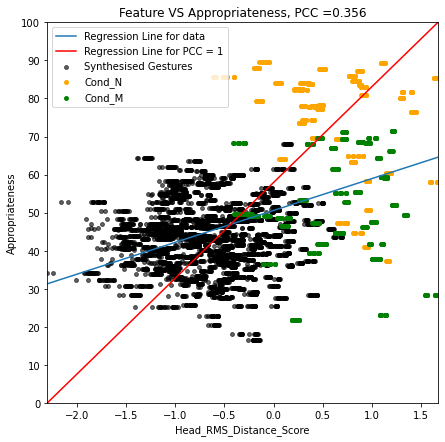

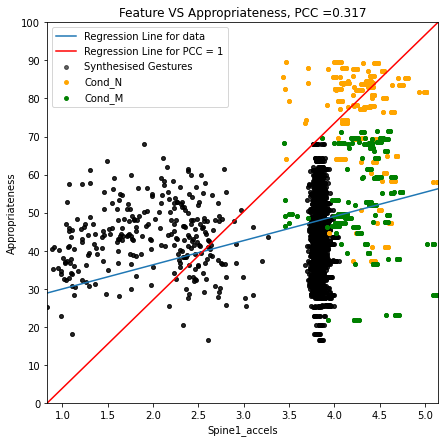

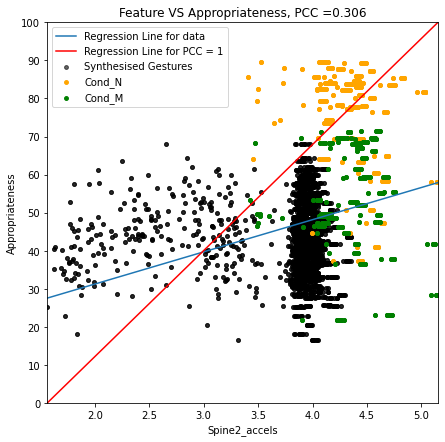

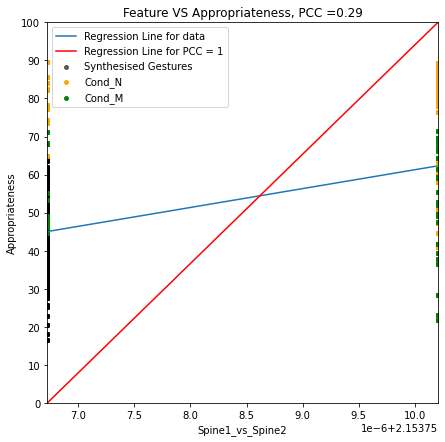

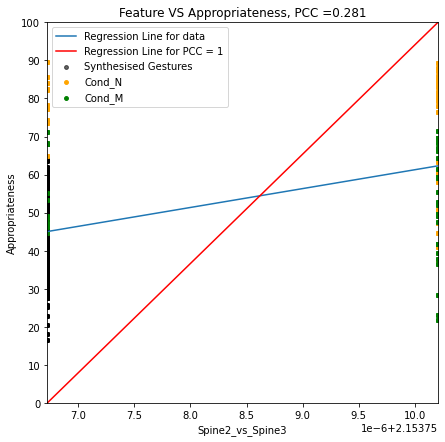

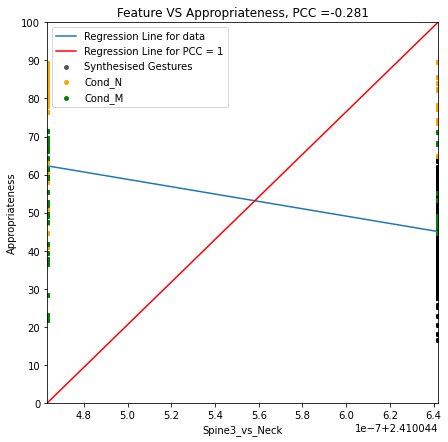

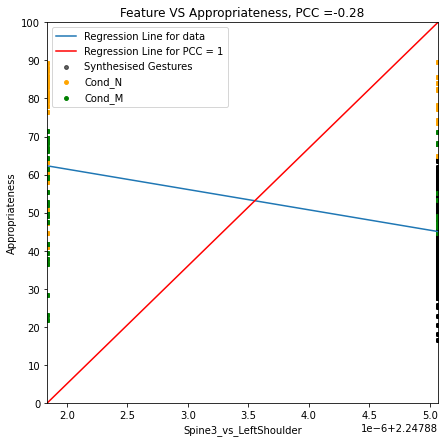

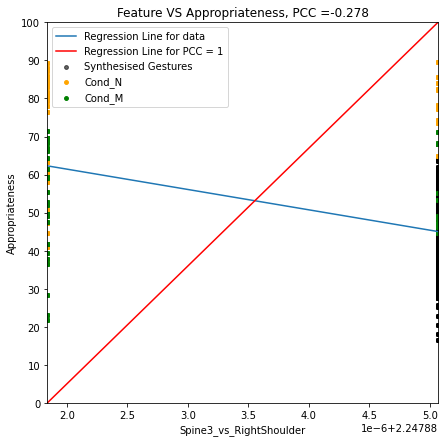

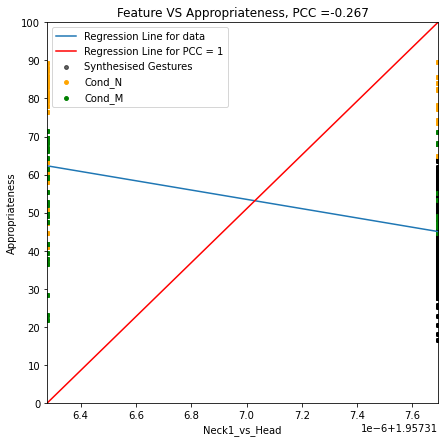

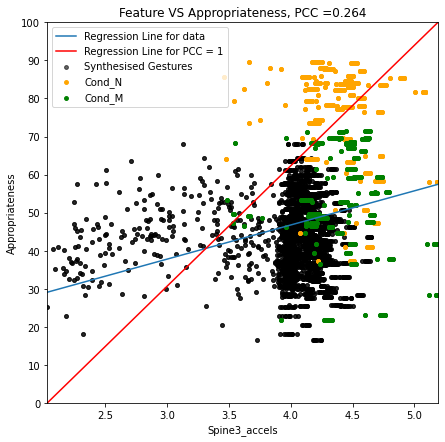

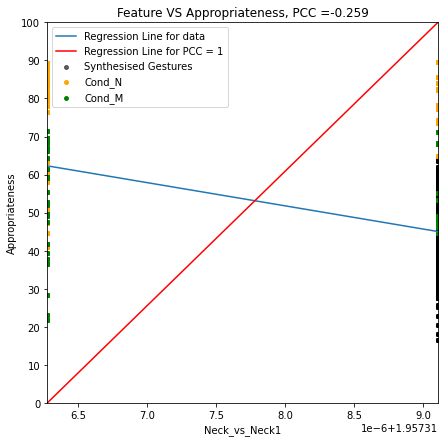

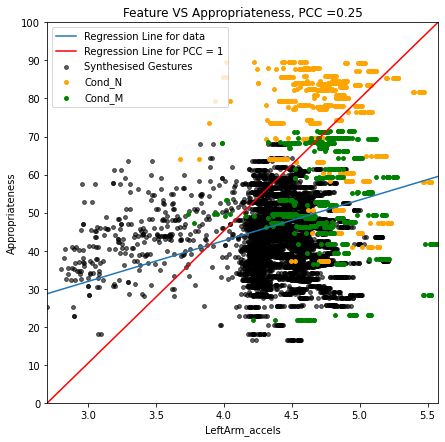

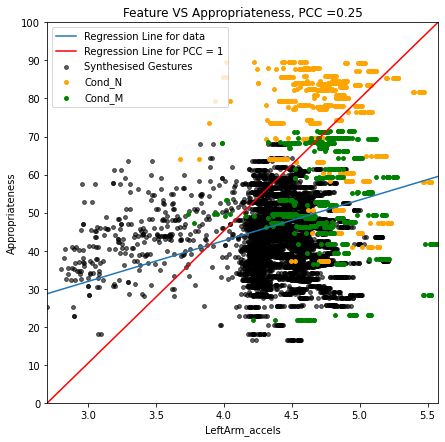

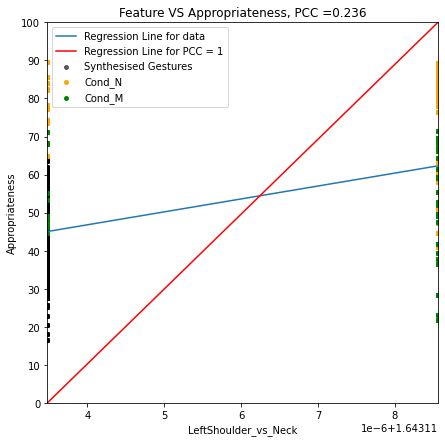

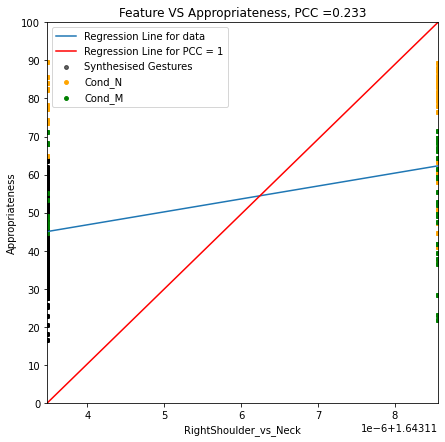

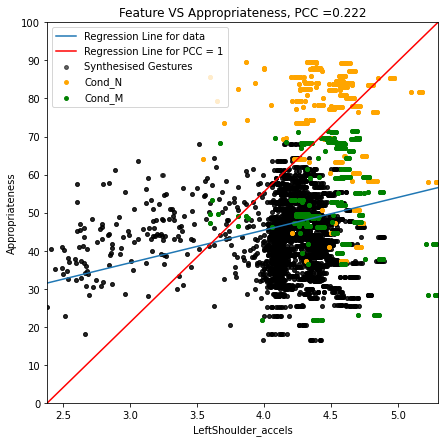

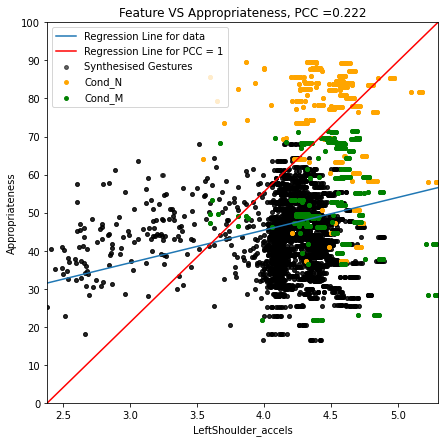

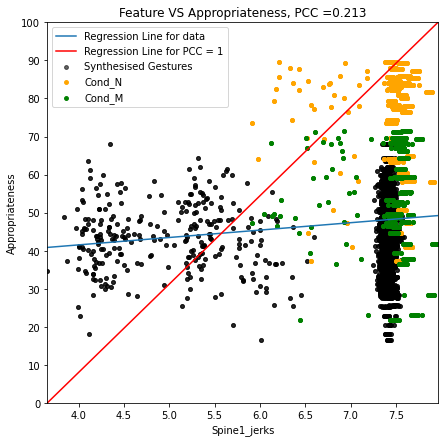

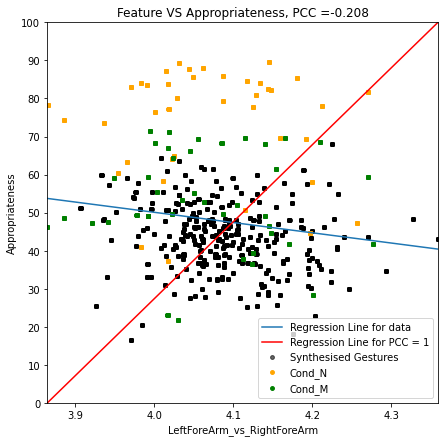

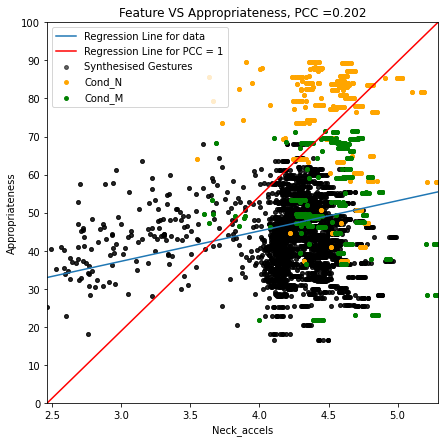

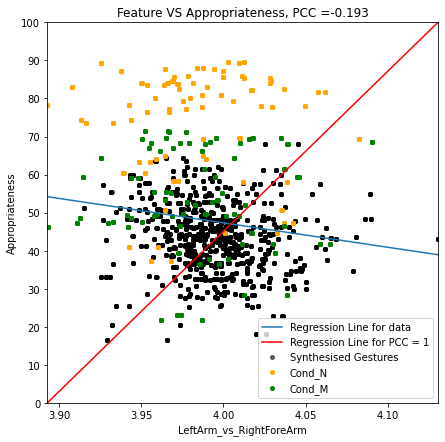

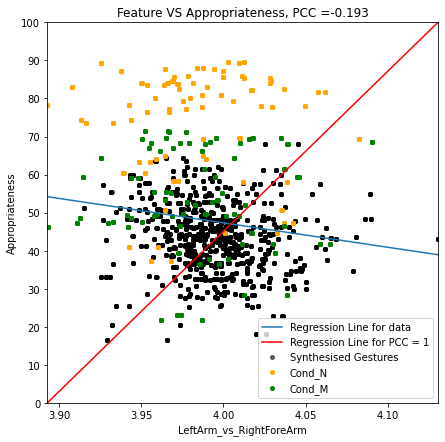

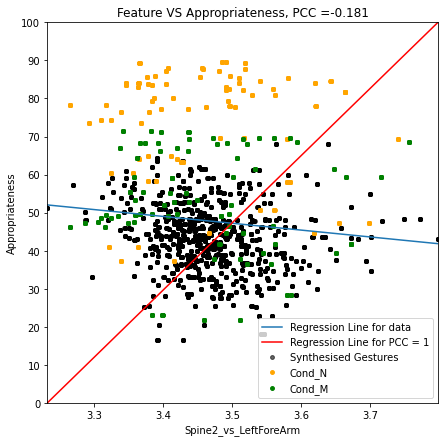

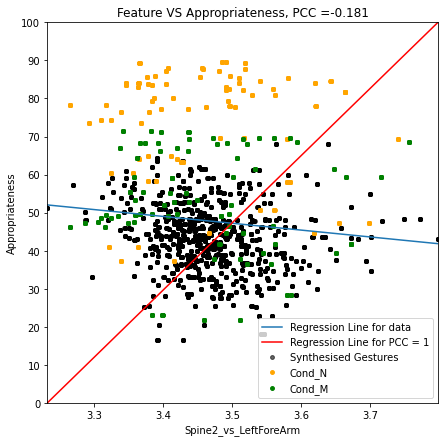

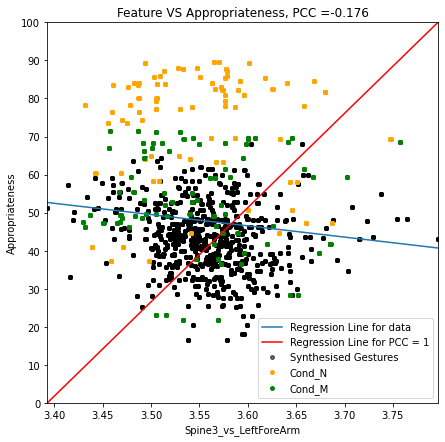

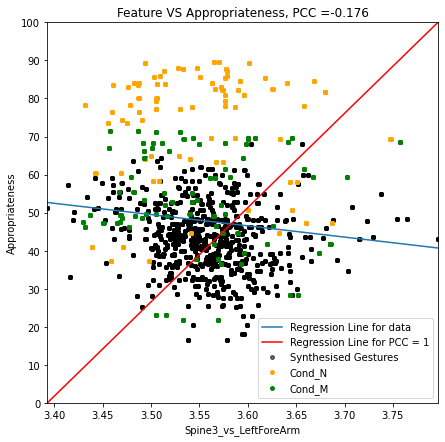

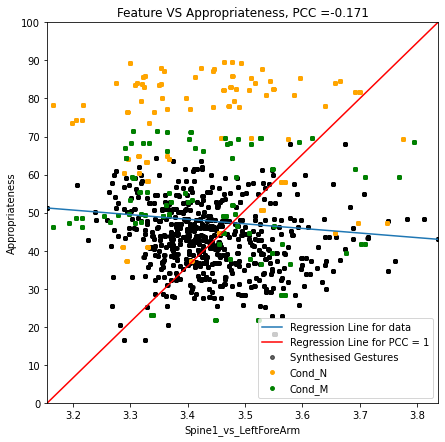

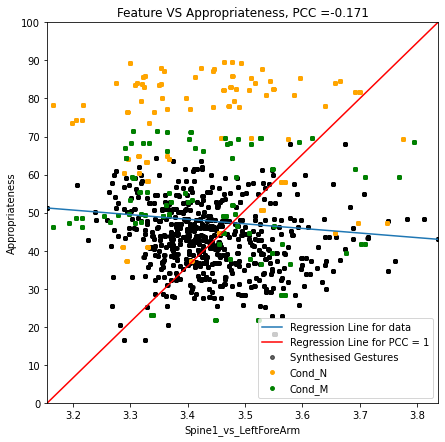

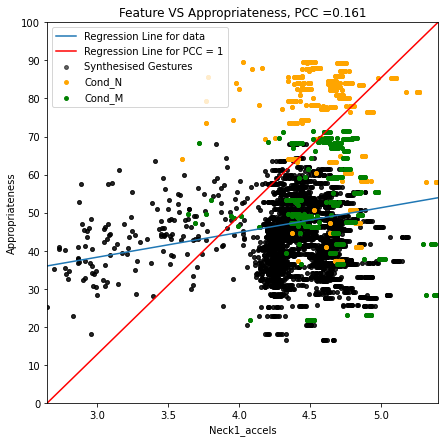

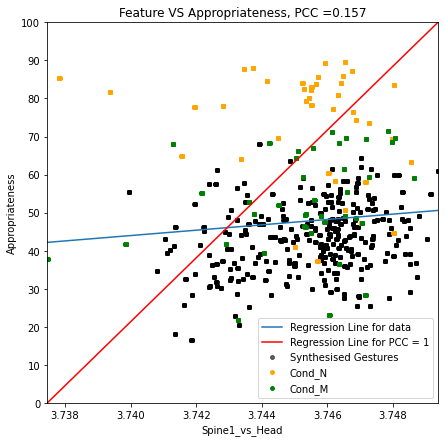

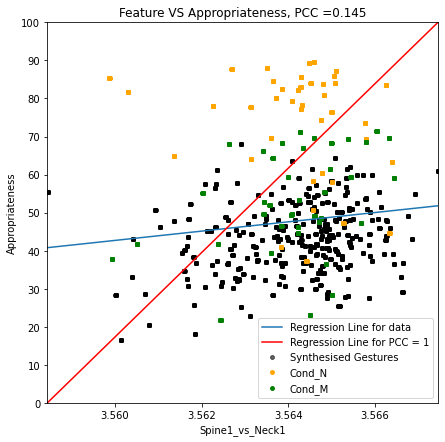

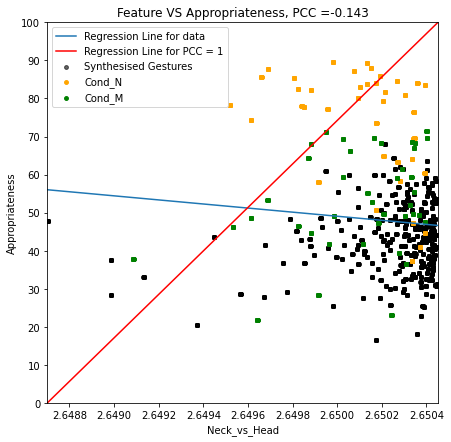

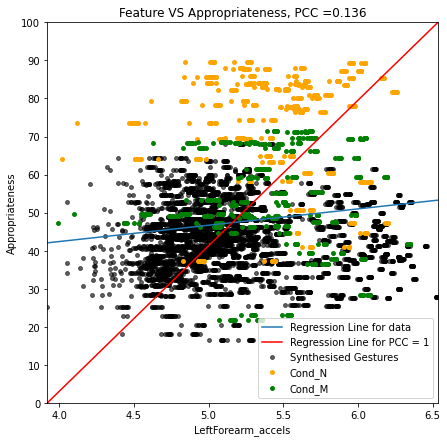

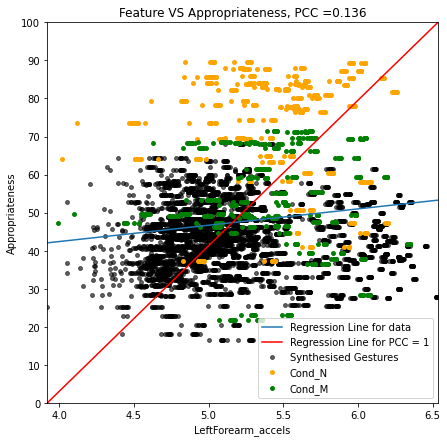

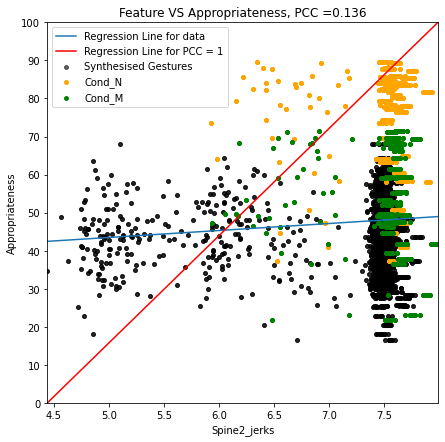

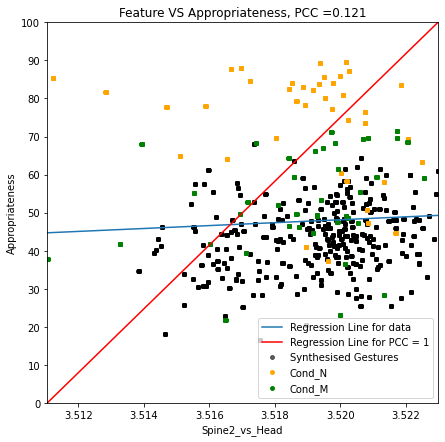

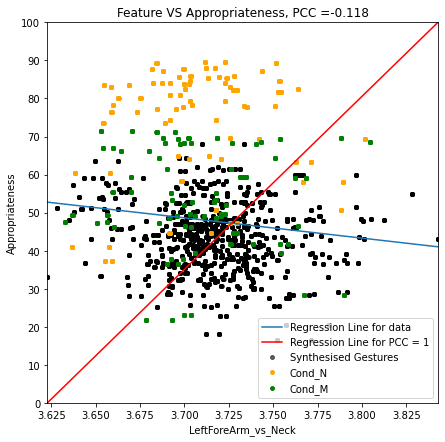

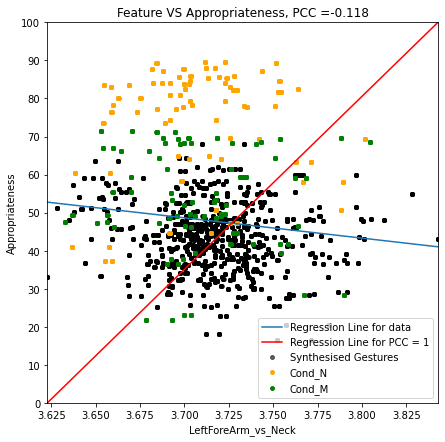

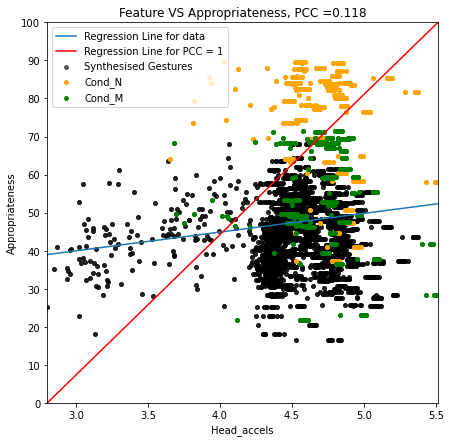

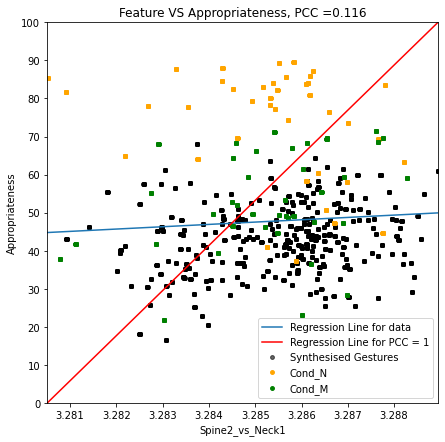

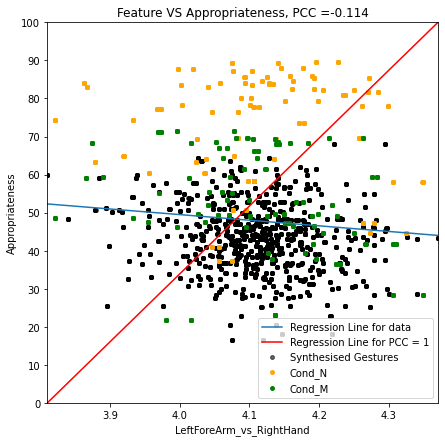

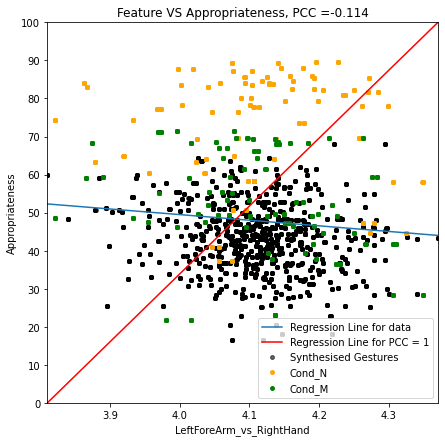

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


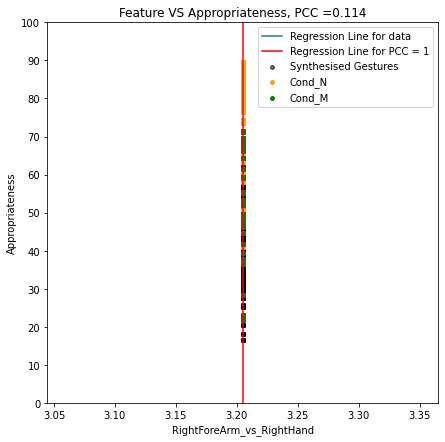

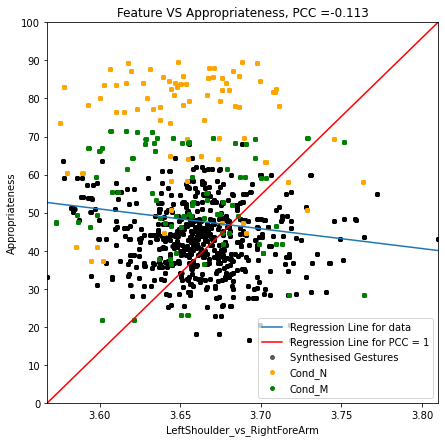

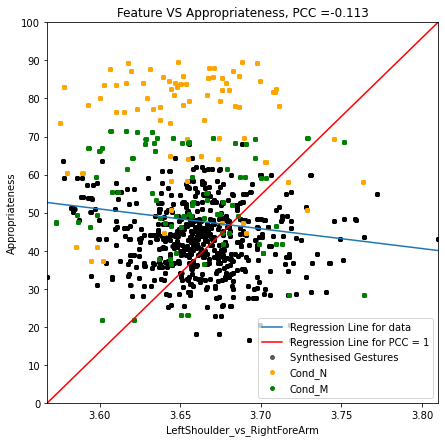

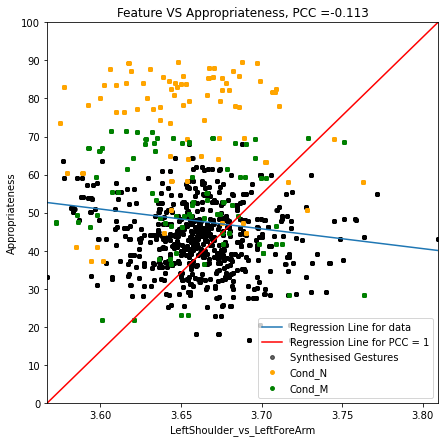

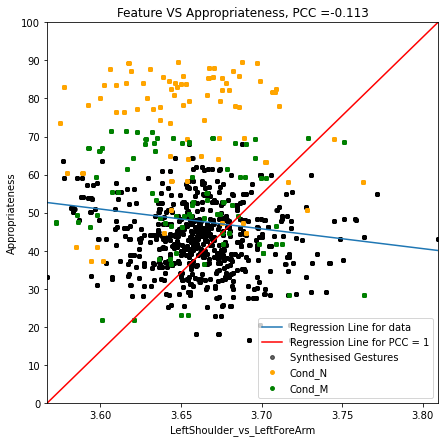

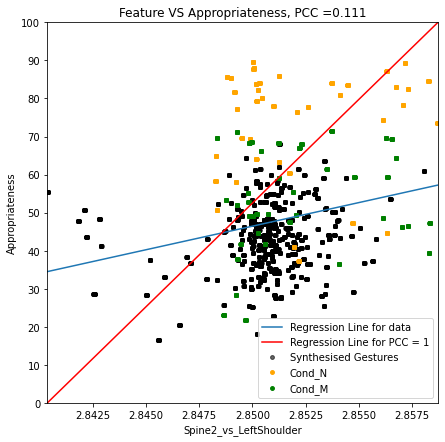

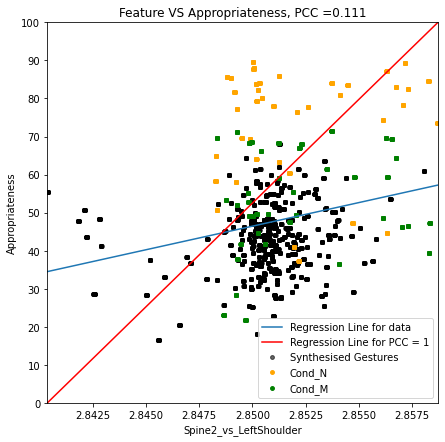

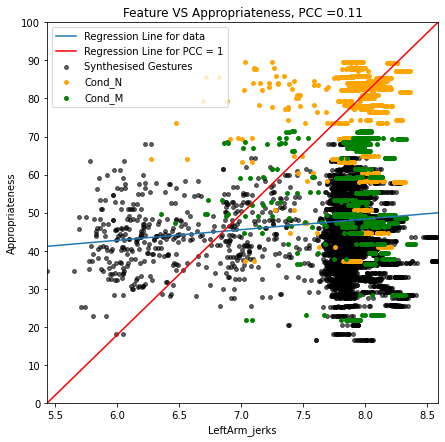

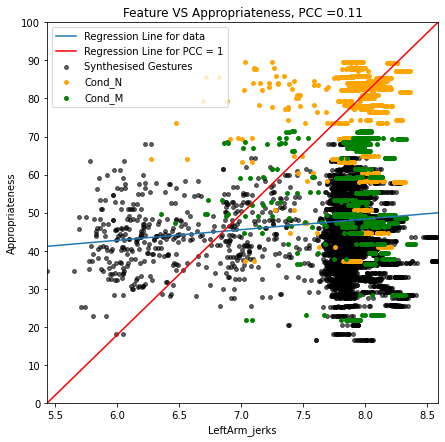

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


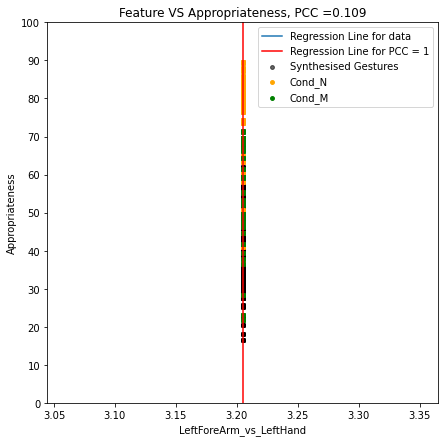

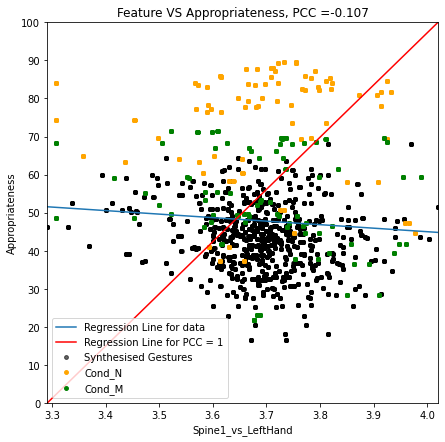

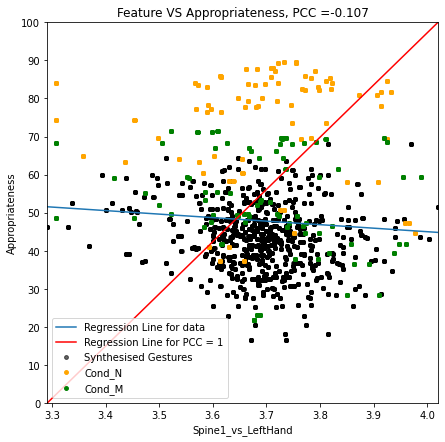

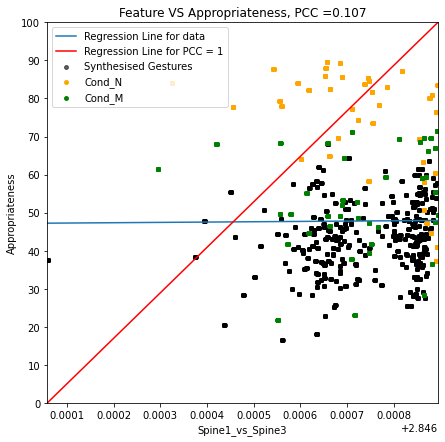

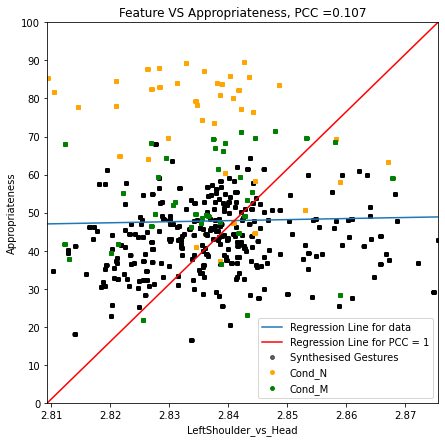

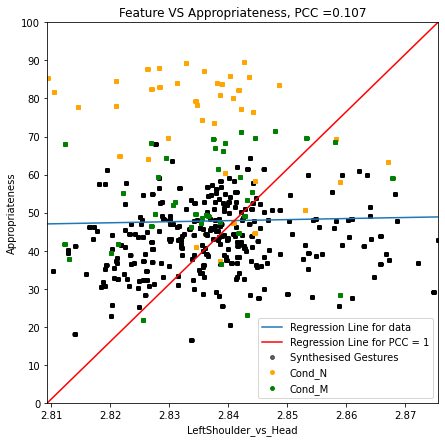

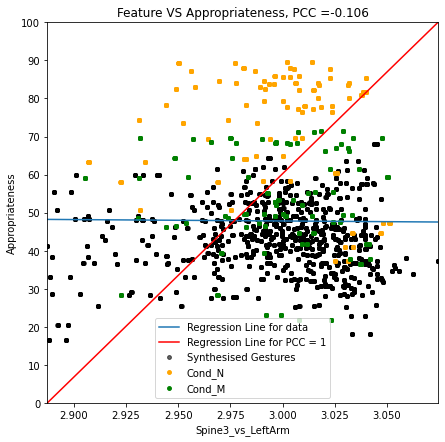

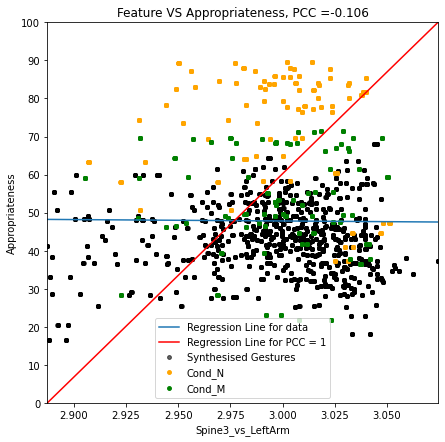

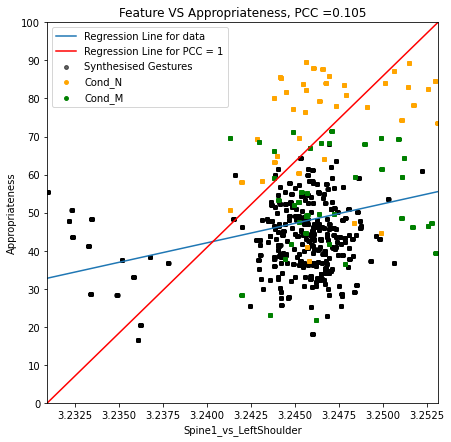

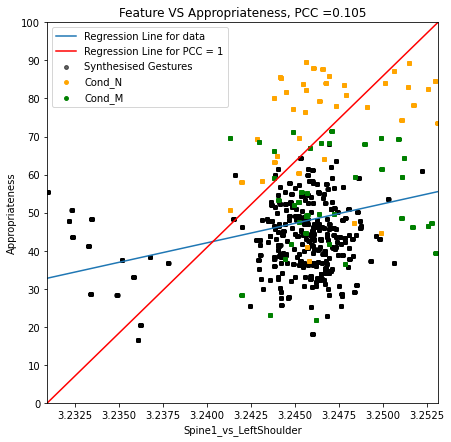

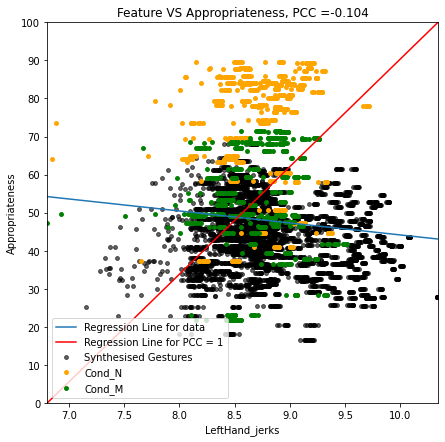

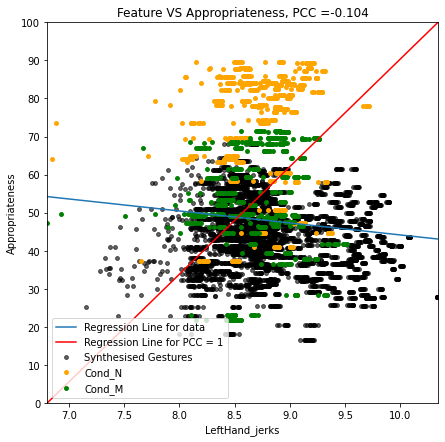

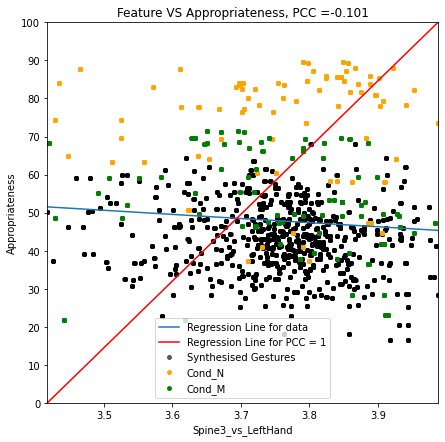

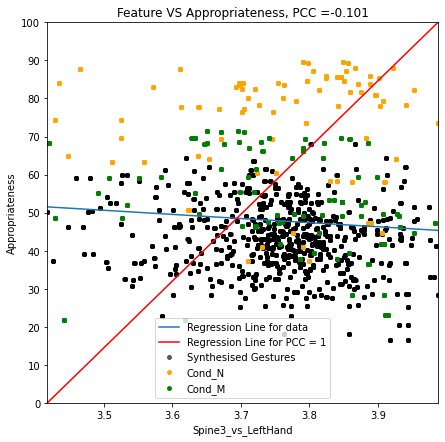

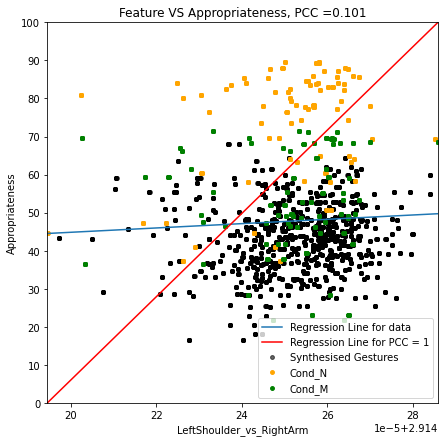

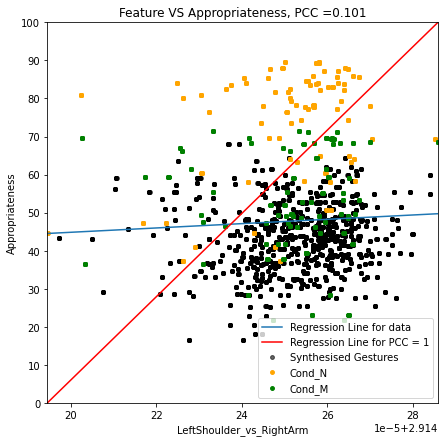

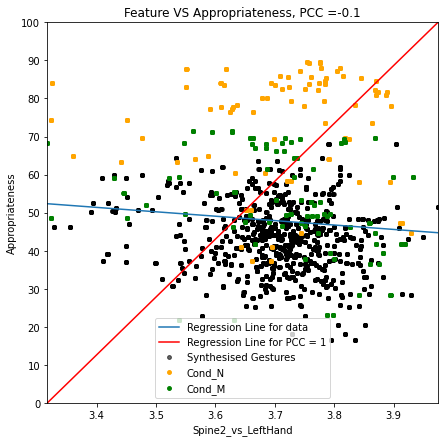

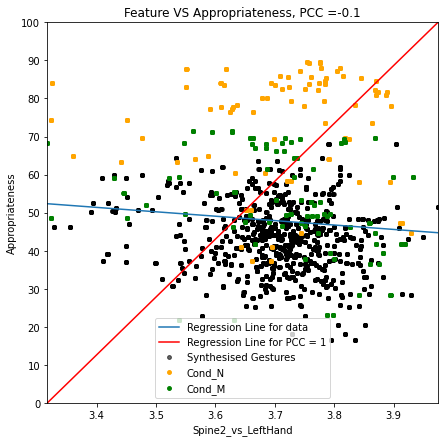

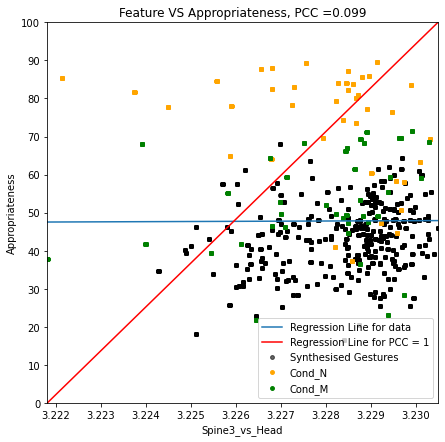

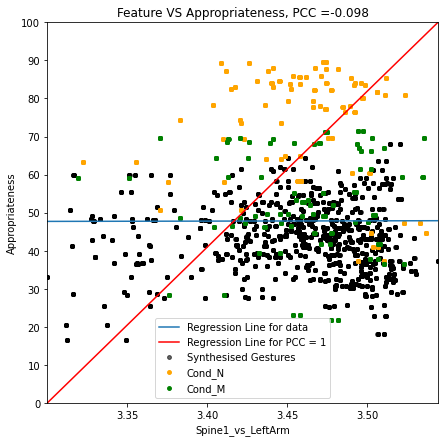

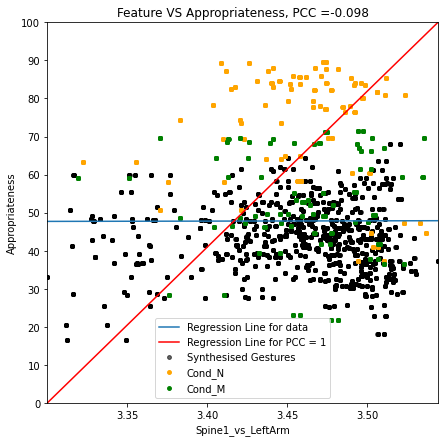

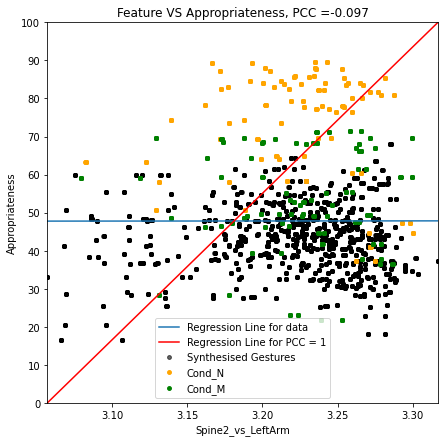

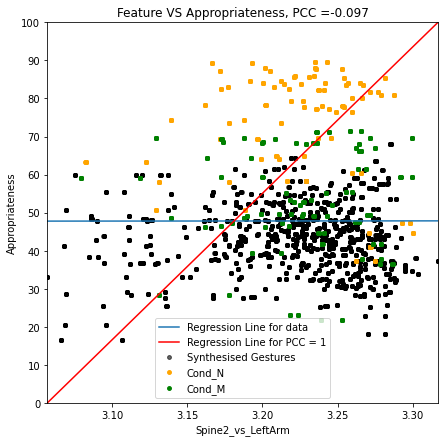

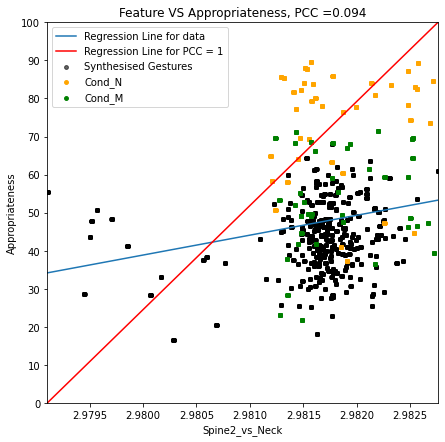

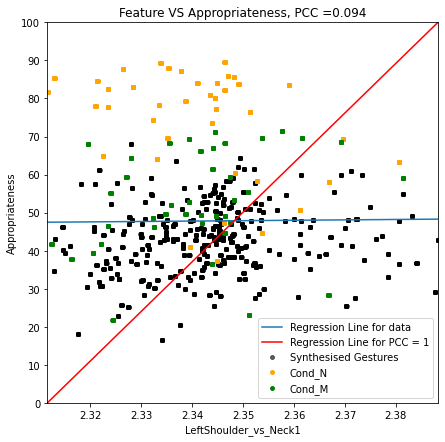

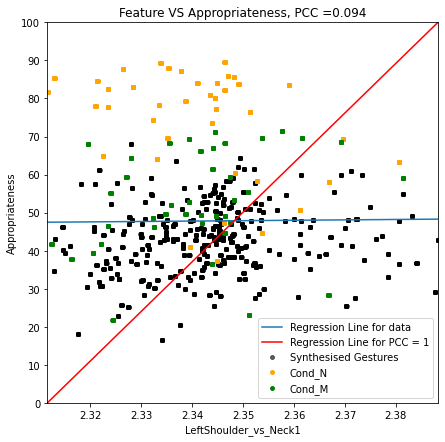

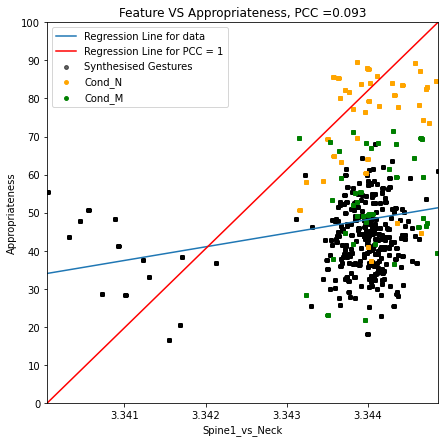

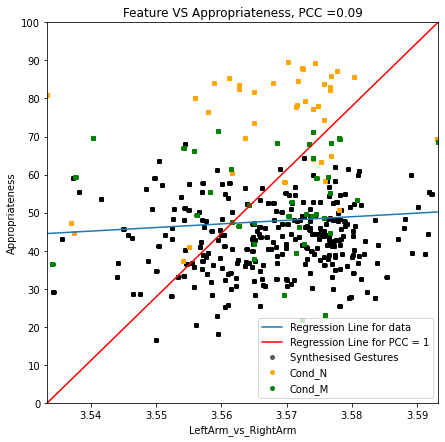

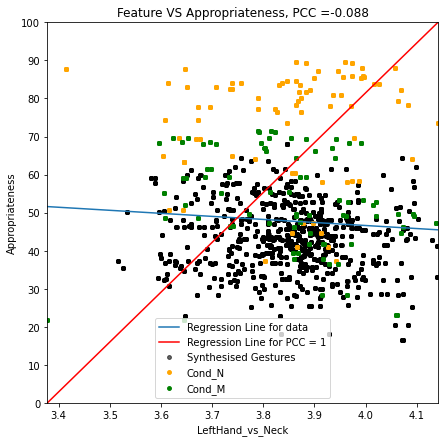

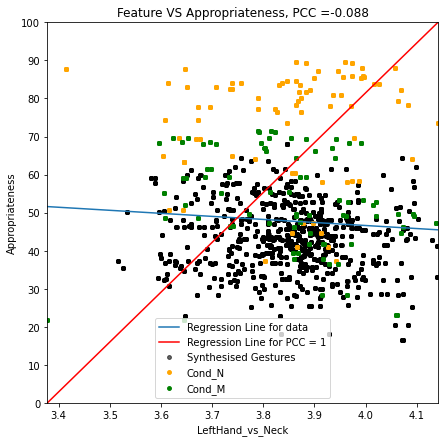

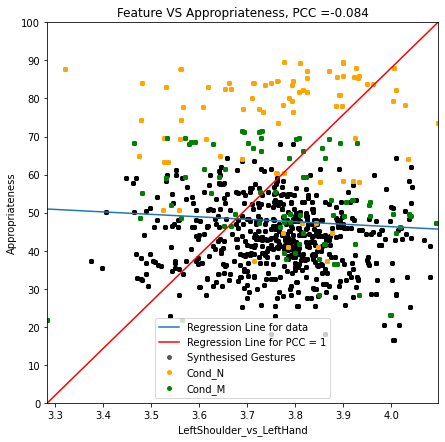

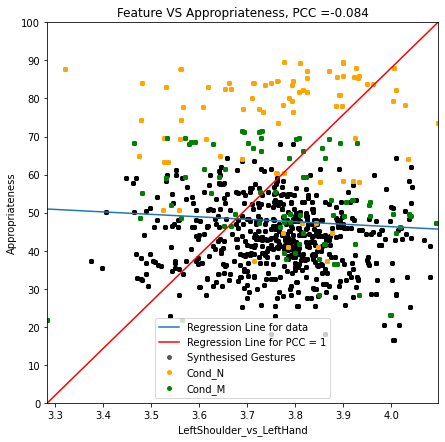

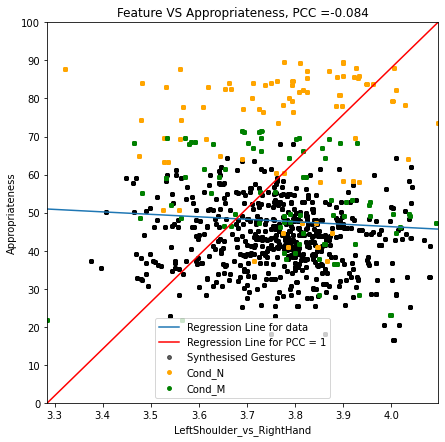

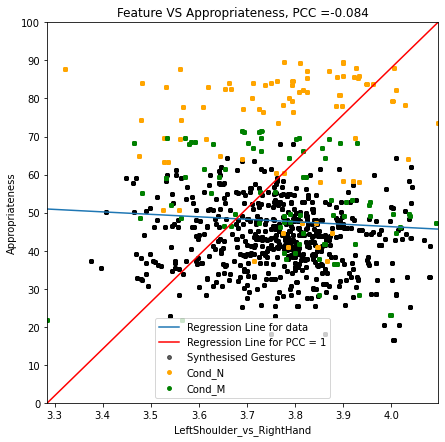

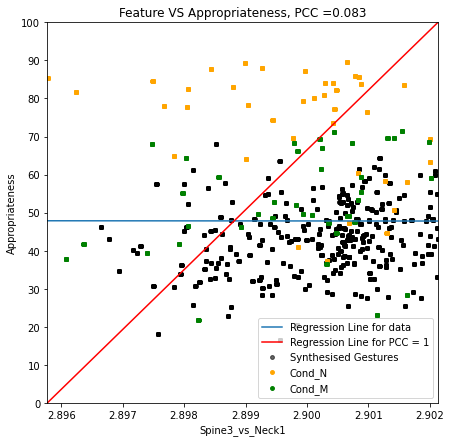

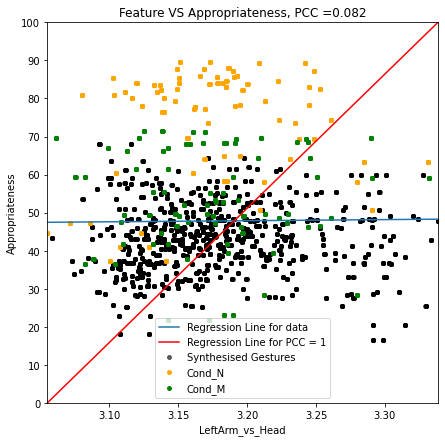

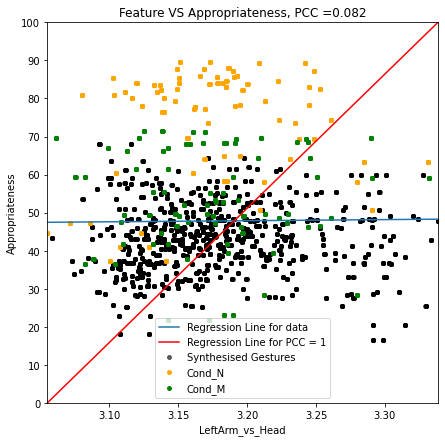

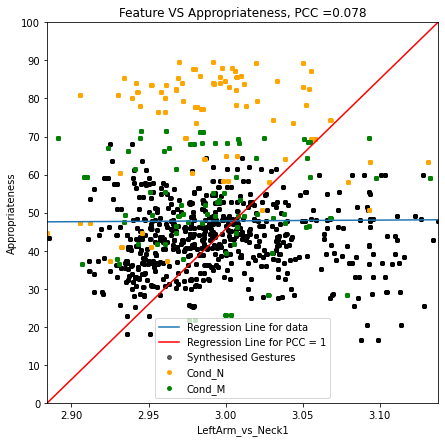

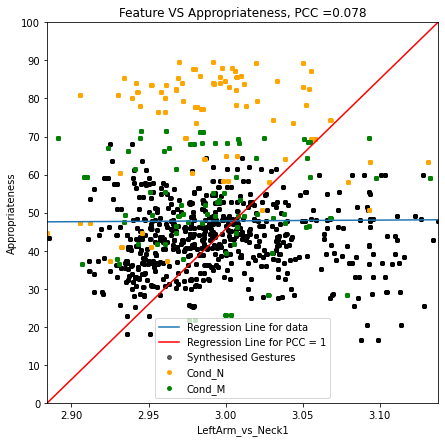

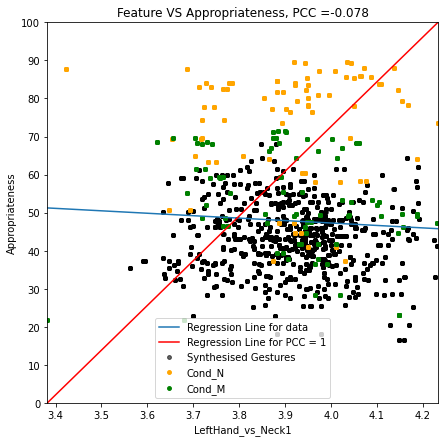

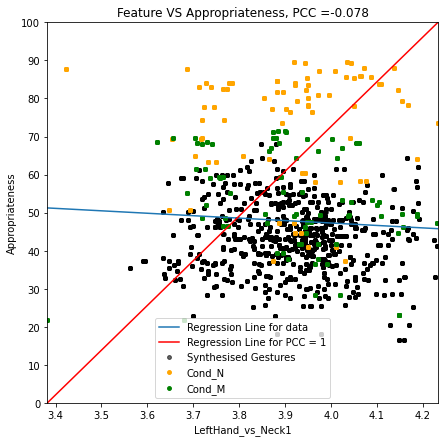

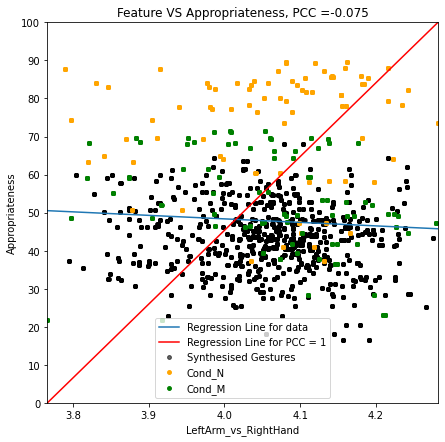

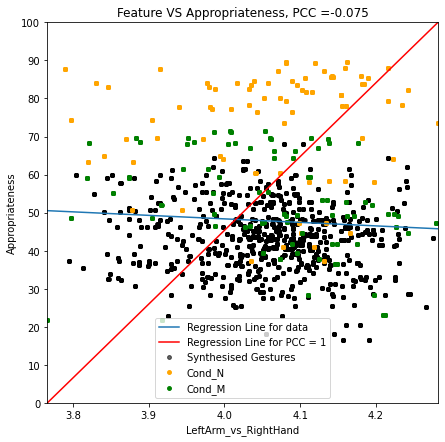

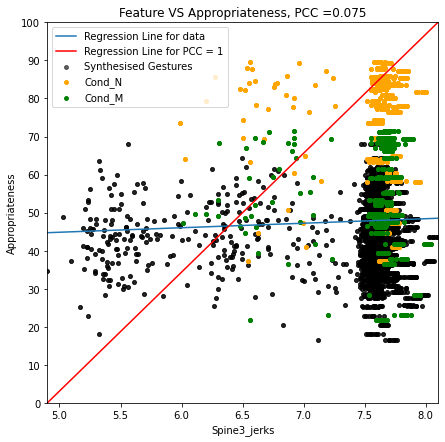

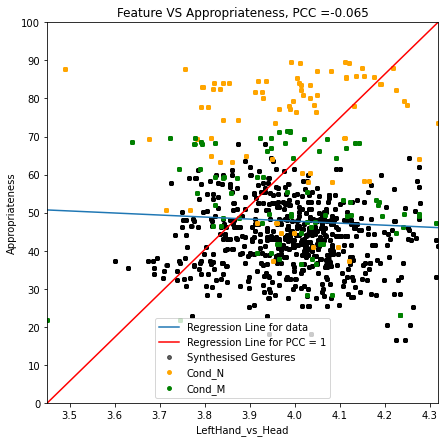

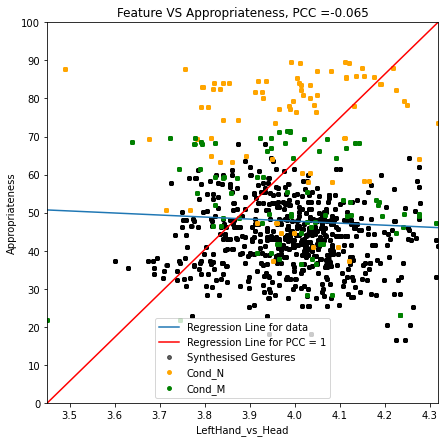

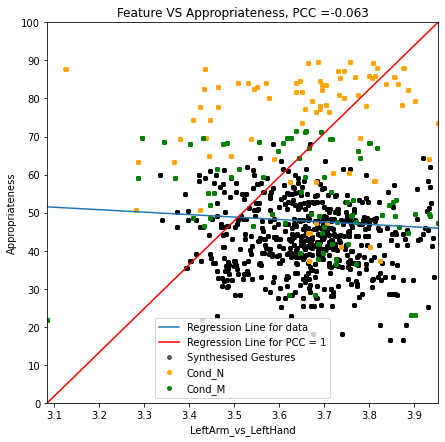

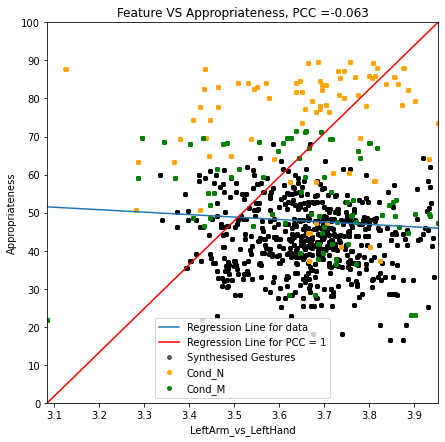

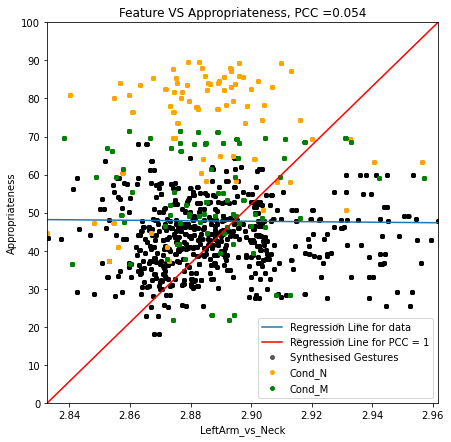

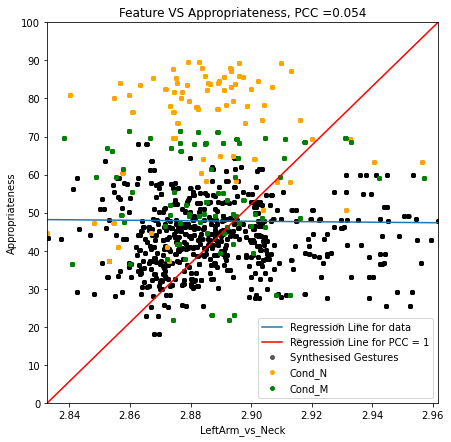

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


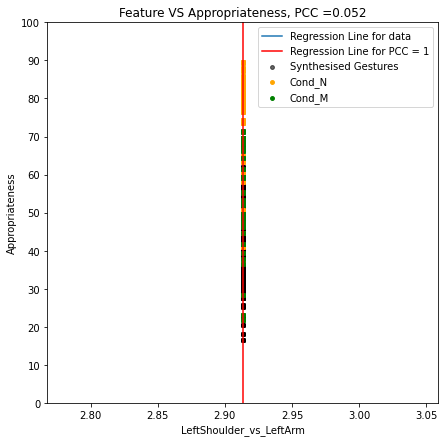

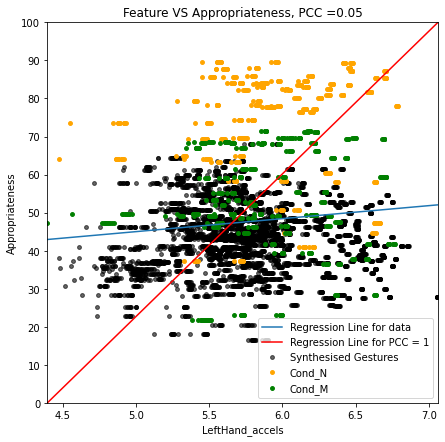

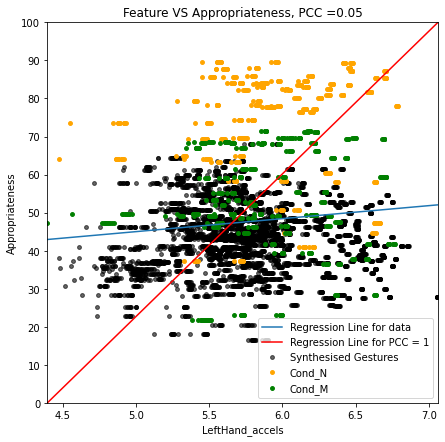

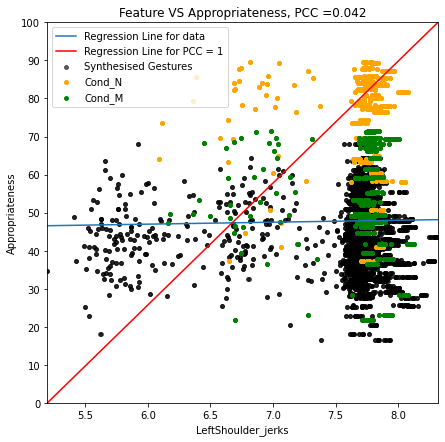

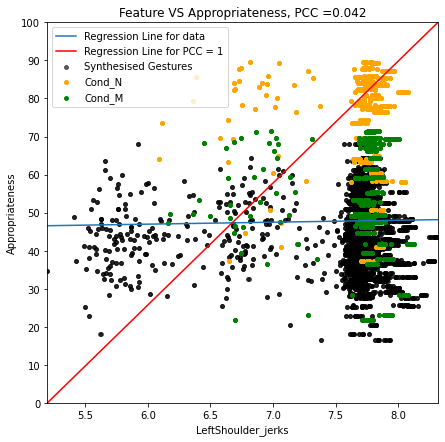

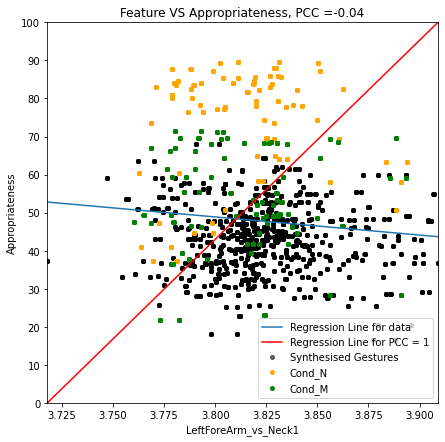

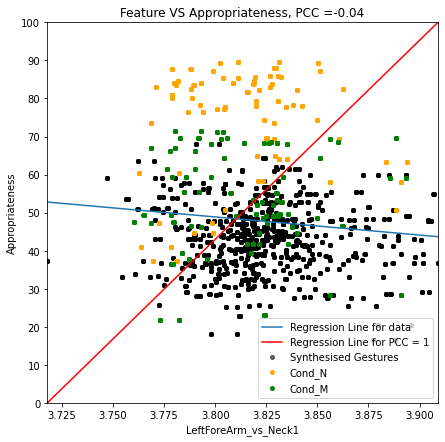

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


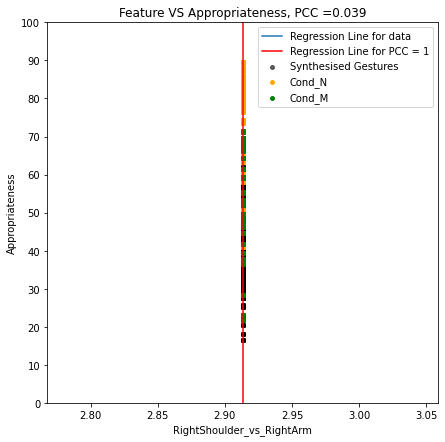

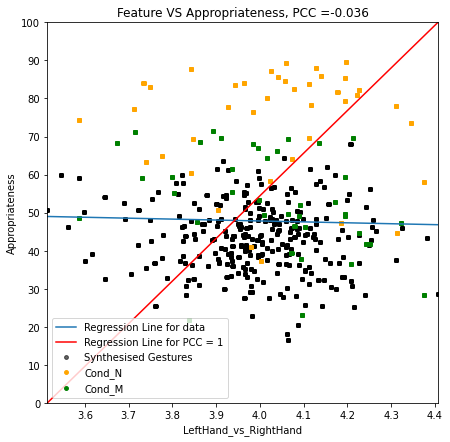

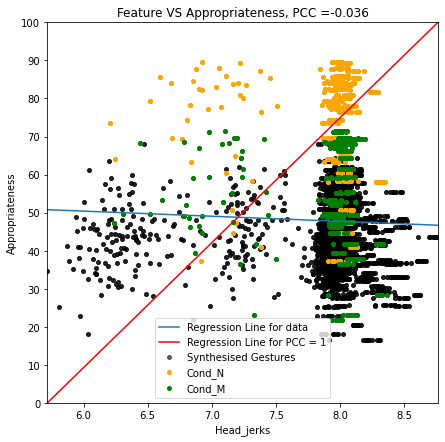

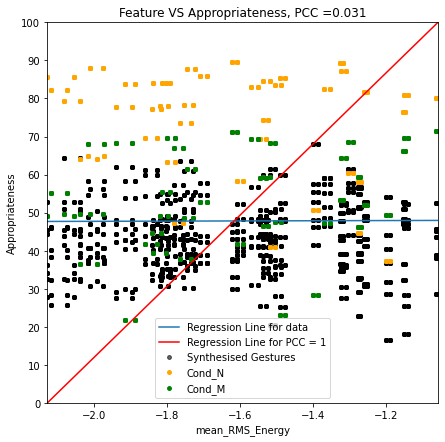

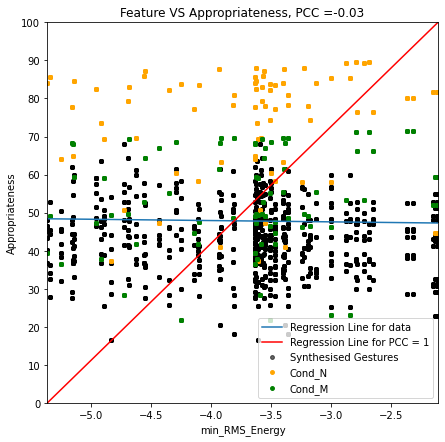

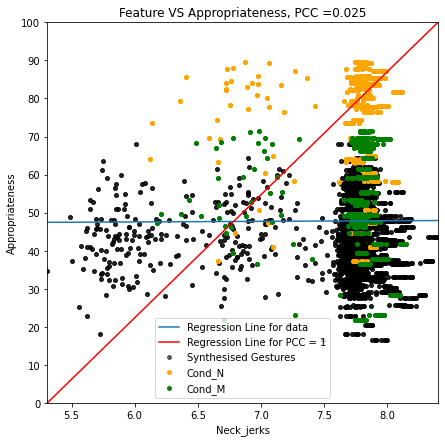

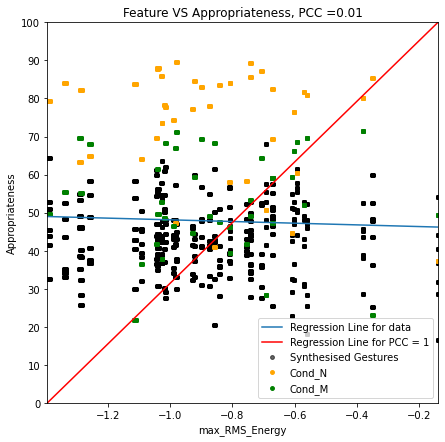

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


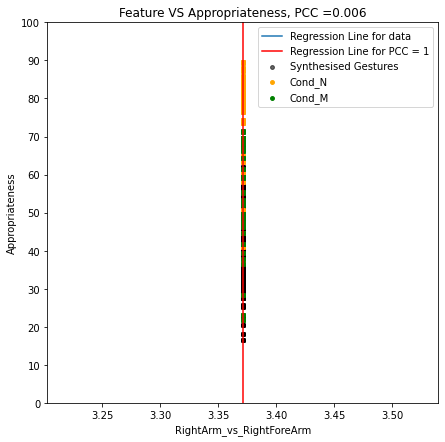

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


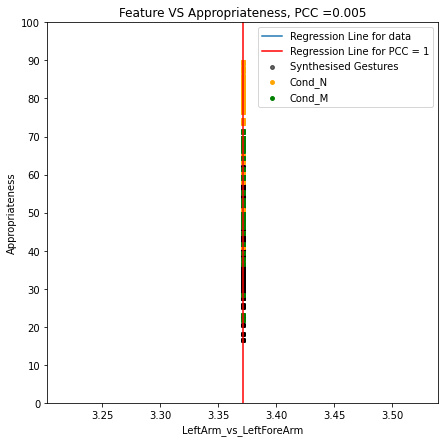

C:\Users\Cameron\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


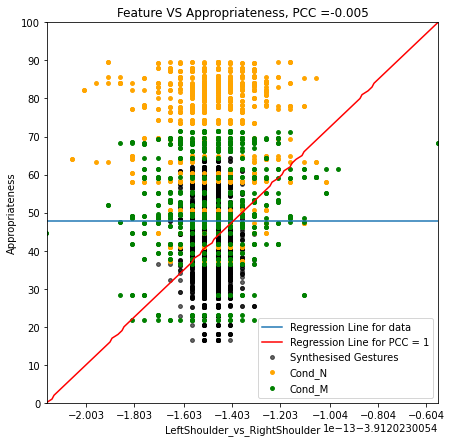

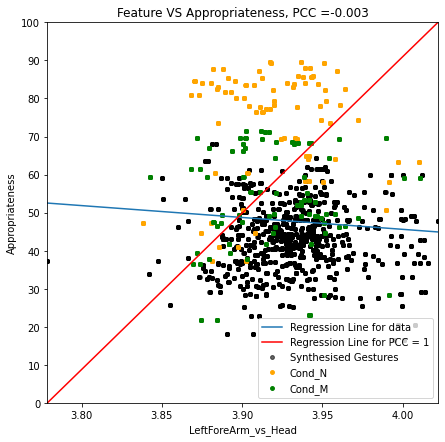

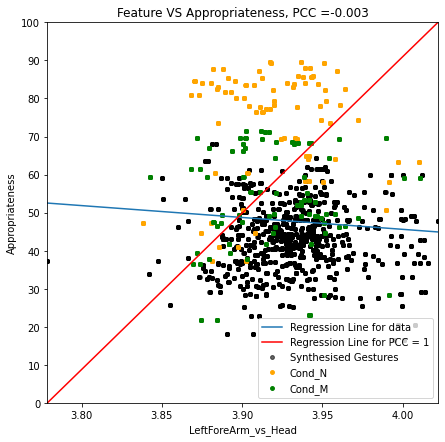

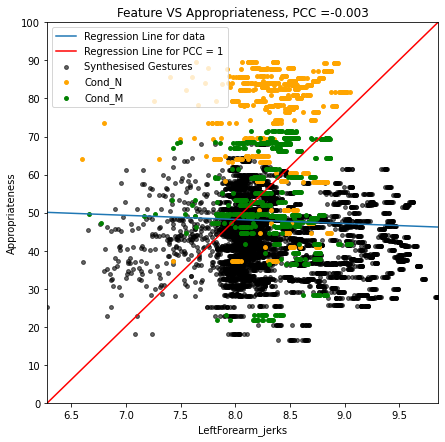

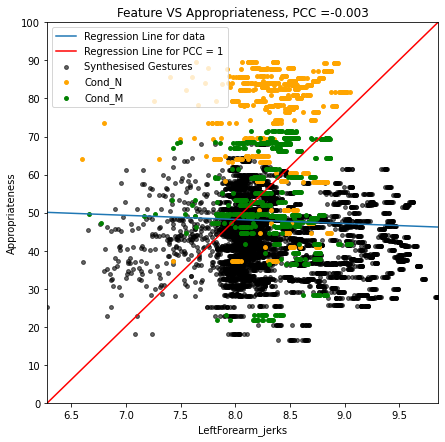

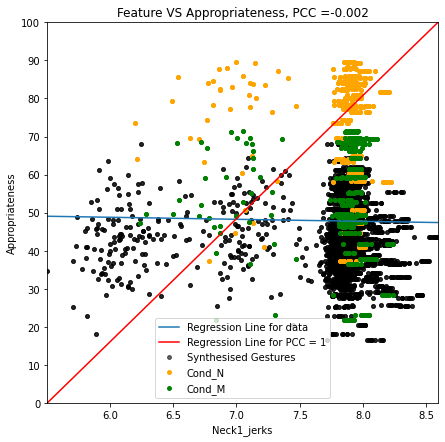

In [15]:
# Highest Plots
n = 136 # n highest plots
for i in range(0,n):
    idx = -1 - i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    m, b = np.polyfit(XX[feature], YY, 1)
    x = np.linspace(np.min(XX[feature]), np.max(XX[feature]), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line for data")
    plt.plot(x, y, "-r", label="Regression Line for PCC = 1")
    plt.scatter(XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])][feature], 
                YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], 
                s=15, c='black', alpha=0.6, label='Synthesised Gestures')
    plt.scatter(XX.loc[['Cond_N' in idx for idx in XX.index]][feature], YY.loc[['Cond_N' in idx for idx in YY.index]], s=15, c='orange',
               label='Cond_N')
    plt.scatter(XX.loc[['Cond_M' in idx for idx in XX.index]][feature], YY.loc[['Cond_M' in idx for idx in YY.index]], s=15, c='green',
               label='Cond_M')
    plt.ylim(0,100)
    plt.xlim(min(XX[feature]), max(XX[feature]))
    plt.ylabel('Appropriateness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Appropriateness, PCC =" + str(round(pcc,3)))
    plt.legend()
    plt.show()

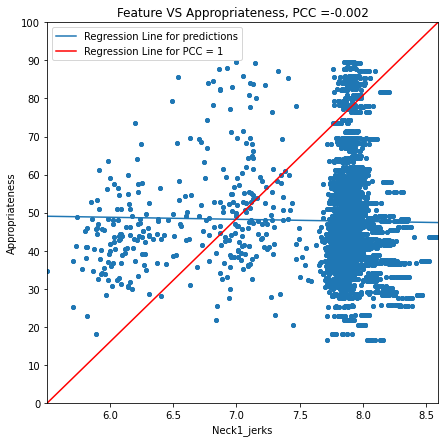

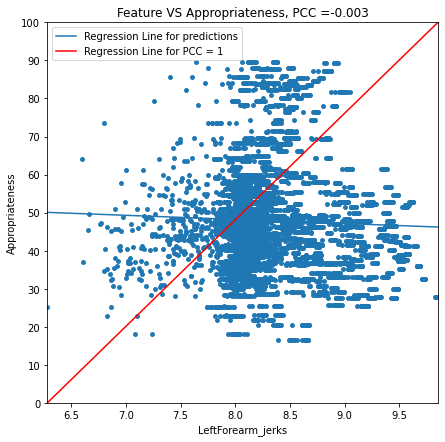

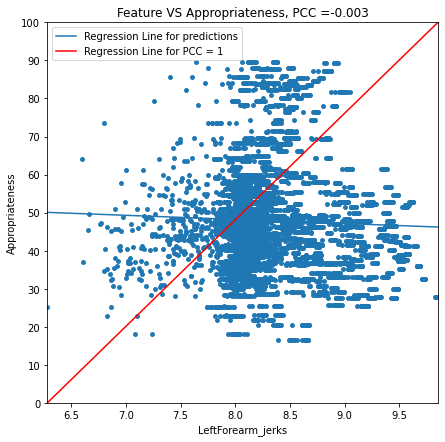

In [16]:
# Lowest Plots
n = 3 # n lowest plots
for i in range(0,n):
    idx = 0 + i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    m, b = np.polyfit(XX[feature], YY, 1)
    x = np.linspace(np.min(XX[feature]), np.max(XX[feature]), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line for predictions")
    plt.plot(x, y, "-r", label="Regression Line for PCC = 1")
    plt.scatter(XX[feature], YY, s=15)
    plt.ylim(0,100)
    plt.xlim(min(XX[feature]), max(XX[feature]))
    plt.ylabel('Appropriateness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Appropriateness, PCC =" + str(round(pcc,3)))
    plt.legend()
    plt.show()

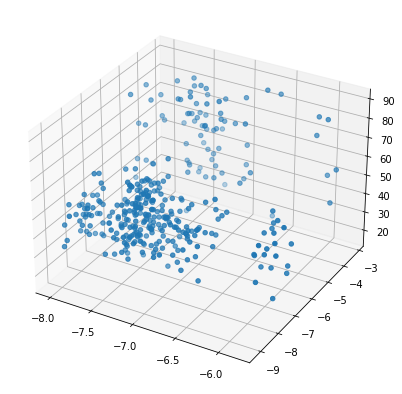

In [186]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(XX['min_RMS_Energy'], XX['Spine1_RMS_Distance_Score'], YY)

Text(0, 0.5, 'Spine1_RMS_Distance_Score')

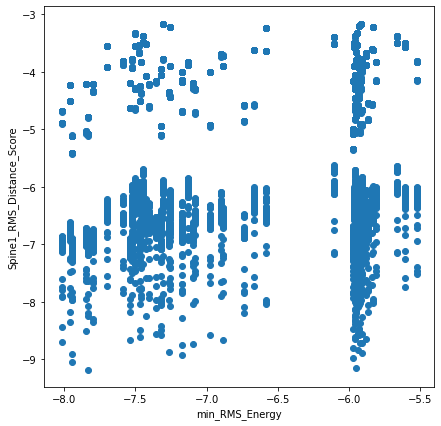

In [15]:
plt.figure(figsize = (7,7))
plt.scatter(XX['min_RMS_Energy'], XX['Spine1_RMS_Distance_Score'])
plt.xlabel('min_RMS_Energy')
plt.ylabel('Spine1_RMS_Distance_Score')

Text(0, 0.5, 'Spine2_RMS_Distance_Score')

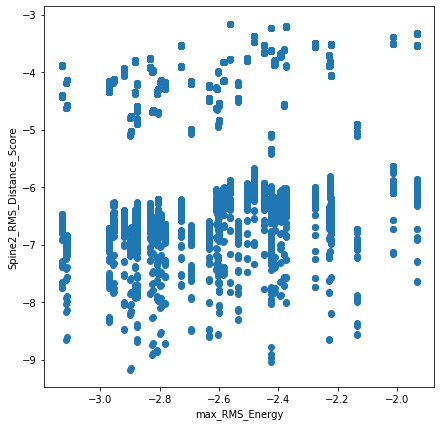

In [16]:
plt.figure(figsize = (7,7))
plt.scatter(XX['max_RMS_Energy'], XX['Spine2_RMS_Distance_Score'])
plt.xlabel('max_RMS_Energy')
plt.ylabel('Spine2_RMS_Distance_Score')

Text(0, 0.5, 'LeftShoulder_RMS_Distance_Score')

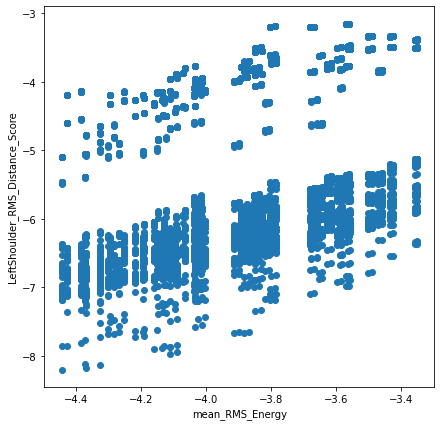

In [17]:
plt.figure(figsize = (7,7))
plt.scatter(XX['mean_RMS_Energy'], XX['LeftShoulder_RMS_Distance_Score'])
plt.xlabel('mean_RMS_Energy')
plt.ylabel('LeftShoulder_RMS_Distance_Score')

Text(0, 0.5, 'Spine2_RMS_Distance_Score')

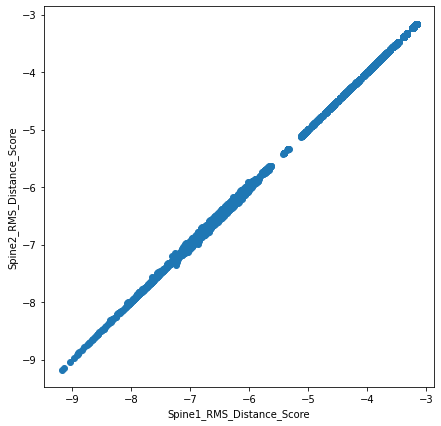

In [18]:
plt.figure(figsize = (7,7))
plt.scatter(XX['Spine1_RMS_Distance_Score'], XX['Spine2_RMS_Distance_Score'])
plt.xlabel('Spine1_RMS_Distance_Score')
plt.ylabel('Spine2_RMS_Distance_Score')

Text(0, 0.5, 'LeftShoulder_RMS_Distance_Score')

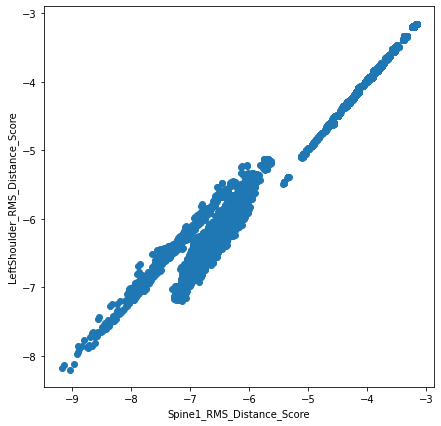

In [19]:
plt.figure(figsize = (7,7))
plt.scatter(XX['Spine1_RMS_Distance_Score'], XX['LeftShoulder_RMS_Distance_Score'])
plt.xlabel('Spine1_RMS_Distance_Score')
plt.ylabel('LeftShoulder_RMS_Distance_Score')

Text(0, 0.5, 'LeftShoulder_RMS_Distance_Score')

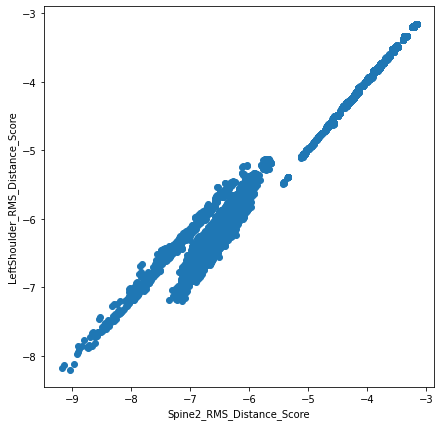

In [20]:
plt.figure(figsize = (7,7))
plt.scatter(XX['Spine2_RMS_Distance_Score'], XX['LeftShoulder_RMS_Distance_Score'])
plt.xlabel('Spine2_RMS_Distance_Score')
plt.ylabel('LeftShoulder_RMS_Distance_Score')